# Object Detection

In [1]:
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-foib0tgd
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-foib0tgd
  Resolved https://github.com/facebookresearch/detectron2.git to commit fd27788985af0f4ca800bca563acdb700bb890e2
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.2/85.2 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 62.9 MB/s eta 0:00:00
  Created wheel for detectron2: filename=detectron2-0.6-cp312-cp312-linux_x86_64.whl size=7085079 sha256=47433efaf4c21cbfd544928207b3b8ff4a76236f0f2dd239f6302796049ad4ae
  Stored in directory: /tmp/pip-ephem-wheel-cache-s_nazd91/wheels/d3/6e/bd/1969578f1456a6be

In [2]:
!git clone https://github.com/facebookresearch/Detic.git --recurse-submodules
%cd Detic
!pip install -r requirements.txt

Cloning into 'Detic'...
remote: Enumerating objects: 210, done.
remote: Counting objects: 100% (111/111), done.
remote: Compressing objects: 100% (55/55), done.
remote: Total 210 (delta 59), reused 56 (delta 56), pack-reused 99 (from 1)
Receiving objects: 100% (210/210), 3.58 MiB | 17.05 MiB/s, done.
Resolving deltas: 100% (85/85), done.
Submodule 'third_party/CenterNet2' (https://github.com/xingyizhou/CenterNet2.git) registered for path 'third_party/CenterNet2'
Submodule 'third_party/Deformable-DETR' (https://github.com/fundamentalvision/Deformable-DETR.git) registered for path 'third_party/Deformable-DETR'
Cloning into '/content/Detic/third_party/CenterNet2'...
remote: Enumerating objects: 13925, done.        
remote: Counting objects: 100% (949/949), done.        
remote: Compressing objects: 100% (101/101), done.        
remote: Total 13925 (delta 887), reused 854 (delta 846), pack-reused 12976 (from 1)        
Receiving objects: 100% (13925/13925), 5.08 MiB | 16.62 MiB/s, done.
Re

In [1]:
%cd /content/Detic

/content/Detic


In [2]:
import torch
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

import sys
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

sys.path.insert(0, '/content/Detic/third_party/CenterNet2/')
from centernet.config import add_centernet_config
sys.path.insert(1, '/content/Detic')
from detic.config import add_detic_config
from detic.modeling.utils import reset_cls_test

/usr/local/lib/python3.12/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/usr/local/lib/python3.12/dist-packages/timm/models/helpers.py:7: FutureWarning: Importing from timm.models.helpers is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
/usr/local/lib/python3.12/dist-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)


In [3]:
cfg = get_cfg()
add_centernet_config(cfg)
add_detic_config(cfg)
cfg.merge_from_file("/content/Detic/configs/Detic_LCOCOI21k_CLIP_SwinB_896b32_4x_ft4x_max-size.yaml")
cfg.MODEL.WEIGHTS = 'https://dl.fbaipublicfiles.com/detic/Detic_LCOCOI21k_CLIP_SwinB_896b32_4x_ft4x_max-size.pth'
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
cfg.MODEL.ROI_BOX_HEAD.ZEROSHOT_WEIGHT_PATH = 'rand'
cfg.MODEL.ROI_HEADS.ONE_CLASS_PER_PROPOSAL = True
# cfg.MODEL.DEVICE='cpu'
predictor = DefaultPredictor(cfg)

/usr/local/lib/python3.12/dist-packages/torch/functional.py:505: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4317.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[11/22 18:37:20 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detic/Detic_LCOCOI21k_CLIP_SwinB_896b32_4x_ft4x_max-size.pth ...


Detic_LCOCOI21k_CLIP_SwinB_896b32_4x_ft4x_max-size.pth: 702MB [00:26, 26.4MB/s]                           


In [4]:
BUILDIN_CLASSIFIER = {
    'lvis': 'datasets/metadata/lvis_v1_clip_a+cname.npy',
    'objects365': 'datasets/metadata/o365_clip_a+cnamefix.npy',
    'openimages': 'datasets/metadata/oid_clip_a+cname.npy',
    'coco': 'datasets/metadata/coco_clip_a+cname.npy',
}

BUILDIN_METADATA_PATH = {
    'lvis': 'lvis_v1_val',
    'objects365': 'objects365_v2_val',
    'openimages': 'oid_val_expanded',
    'coco': 'coco_2017_val',
}

vocabulary = 'lvis'
metadata = MetadataCatalog.get(BUILDIN_METADATA_PATH[vocabulary])
classifier = BUILDIN_CLASSIFIER[vocabulary]
num_classes = len(metadata.thing_classes)
reset_cls_test(predictor.model, classifier, num_classes)

Resetting zs_weight datasets/metadata/lvis_v1_clip_a+cname.npy


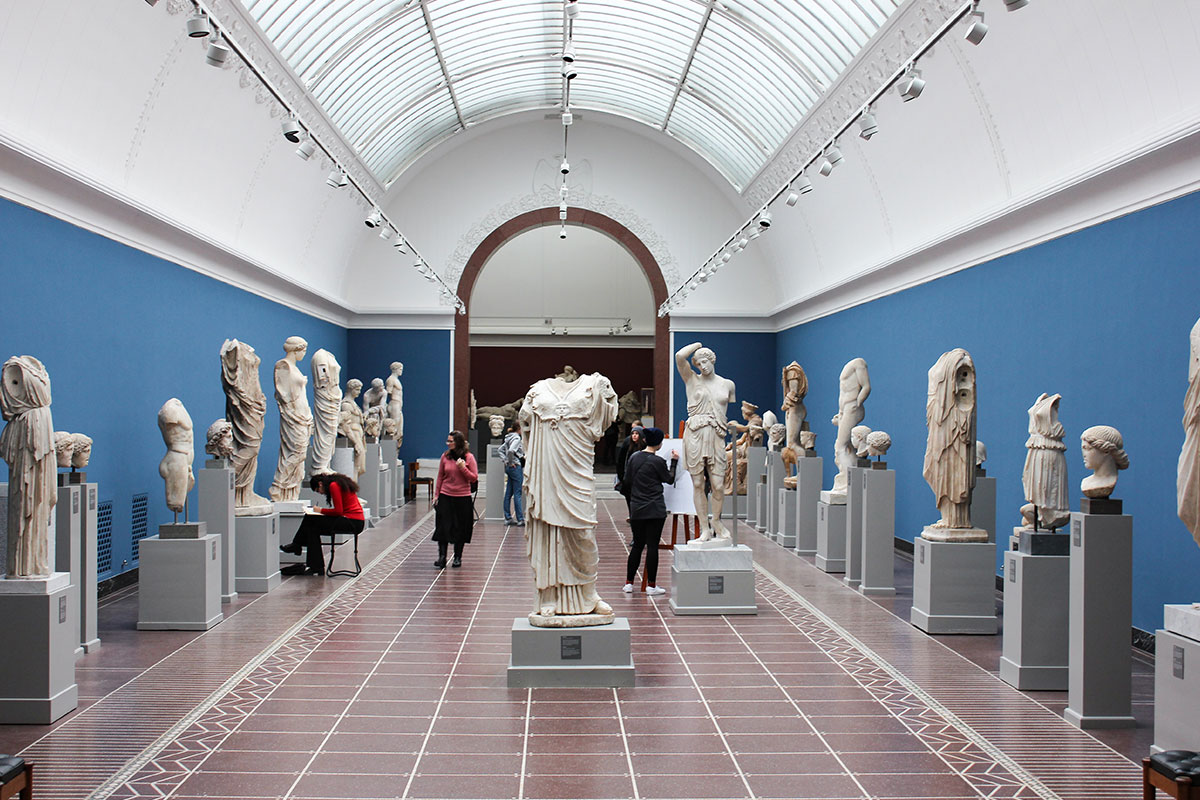

In [5]:
!wget 'https://northernvirginiamag.com/wp-content/uploads/2020/03/statues-in-museums.jpg' -P /content/ -q
im = cv2.imread("/content/statues-in-museums.jpg")
cv2_imshow(im)

371


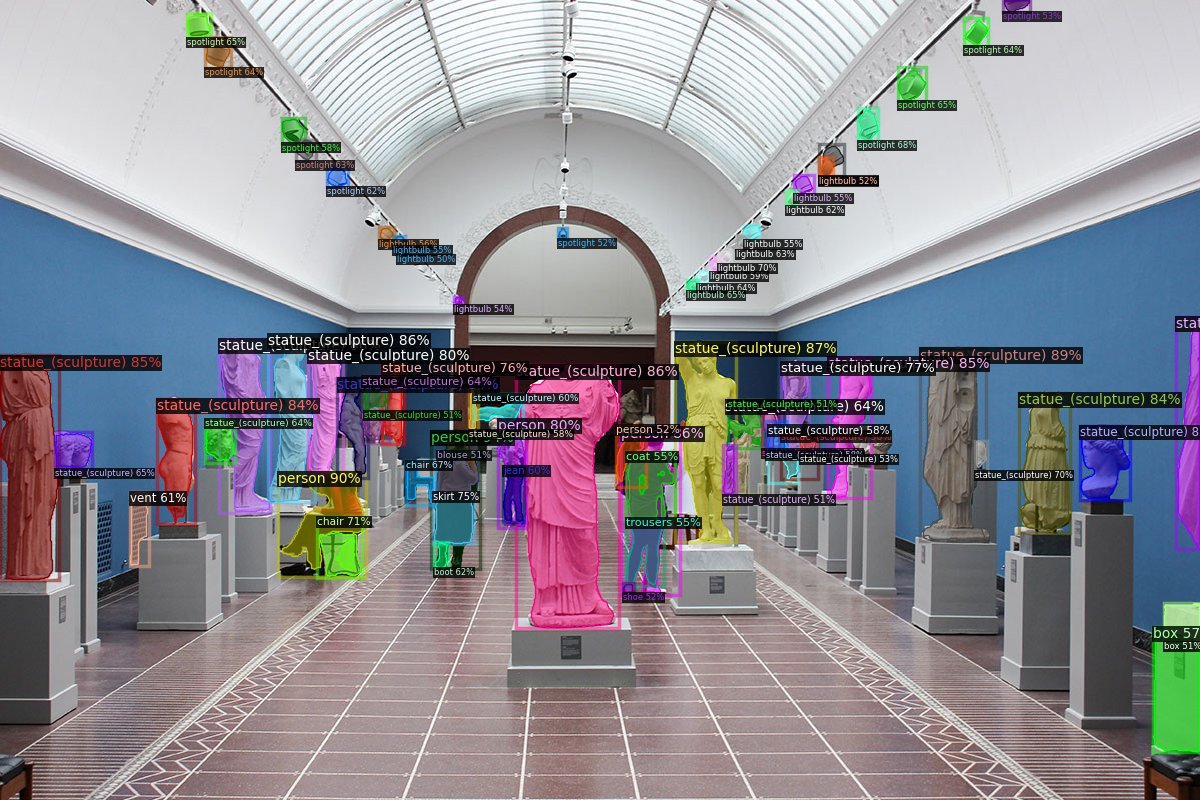

In [7]:
import time
strt = int(round(time.time() * 1000))
outputs = predictor(im)
print(int(round(time.time() * 1000)) - strt)
v = Visualizer(im[:, :, ::-1], metadata)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])

# Depth Estimation

In [8]:
%cd /content

/content


In [9]:
!pip install -q transformers

In [10]:
from PIL import Image

image = Image.open("/content/statues-in-museums.jpg")

preprocessor_config.json:   0%|          | 0.00/442 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/149M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/149M [00:00<?, ?B/s]

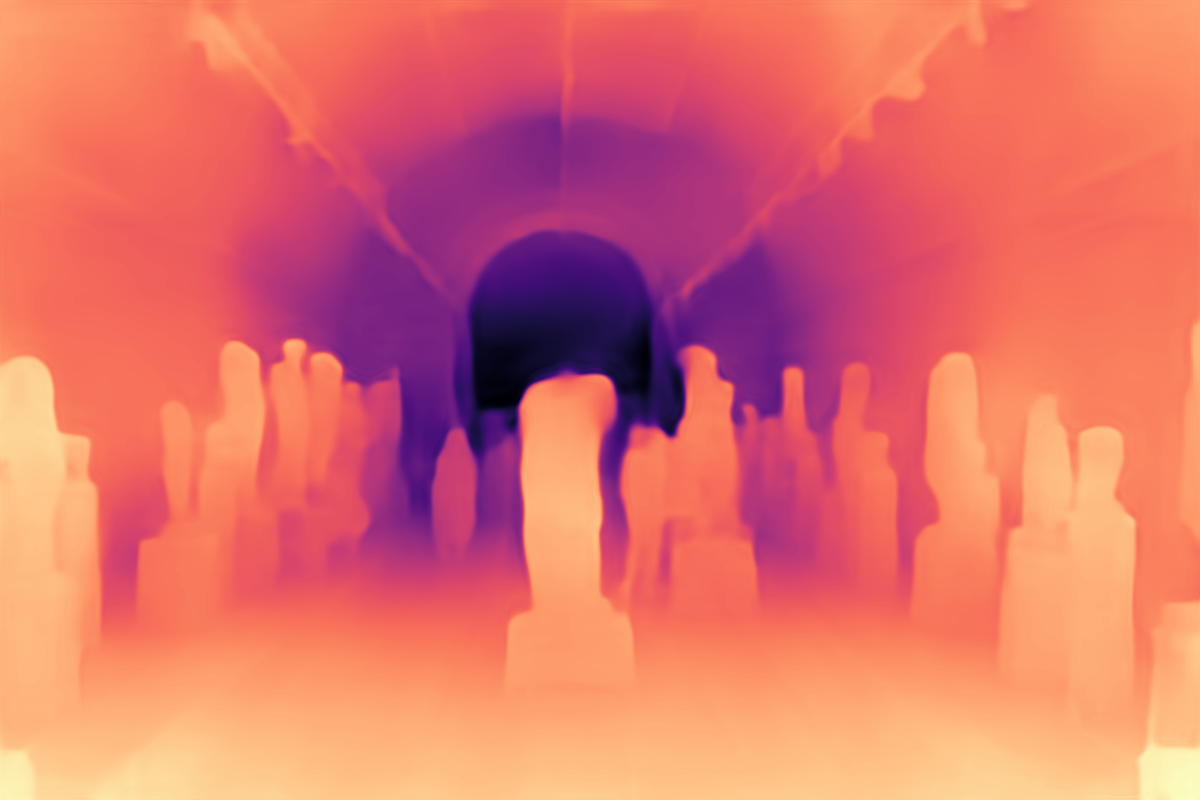

In [11]:
from transformers import AutoImageProcessor, DPTForDepthEstimation, Dinov2Model
import torch
import numpy as np

import matplotlib


image_processor = AutoImageProcessor.from_pretrained("facebook/dpt-dinov2-small-nyu", use_fast=True)
model = DPTForDepthEstimation.from_pretrained("facebook/dpt-dinov2-small-nyu")

inputs = image_processor(images=image, return_tensors="pt")

with torch.no_grad():
    outputs = model(**inputs)
    predicted_depth = outputs.predicted_depth

prediction = torch.nn.functional.interpolate(
    predicted_depth.unsqueeze(1),
    size=image.size[::-1],
    mode="bicubic",
    align_corners=False,
)


def render_depth(values, colormap_name="magma_r") -> Image:
    min_value, max_value = values.min(), values.max()
    normalized_values = (values - min_value) / (max_value - min_value)

    colormap = matplotlib.colormaps[colormap_name]
    colors = colormap(normalized_values, bytes=True)
    colors = colors[:, :, :3]
    return Image.fromarray(colors)

depth_image = render_depth(prediction.squeeze().cpu())

display(depth_image)

# object detection + depth estimation

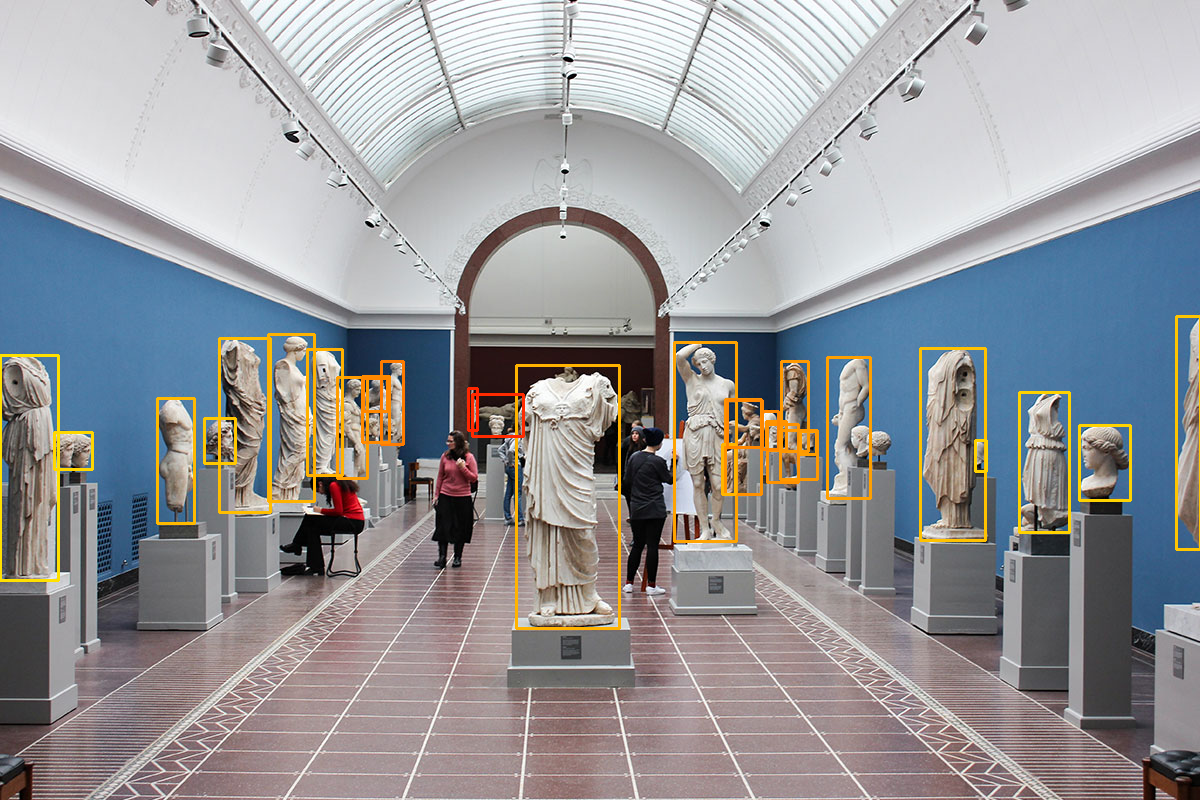

In [12]:
pil_img = Image.open("/content/statues-in-museums.jpg")

pil_img = pil_img.convert("RGB")

image = cv2.cvtColor(np.array(pil_img), cv2.COLOR_RGB2BGR)

outputs = predictor(image)


inputs = image_processor(images=pil_img, return_tensors="pt")

with torch.no_grad():
    depth_result = model(**inputs)
    predicted_depth = depth_result.predicted_depth

result = torch.nn.functional.interpolate(
    predicted_depth.unsqueeze(1),
    size=pil_img.size[::-1],
    mode="bicubic",
    align_corners=False,
)

result_min, result_max = result.min(), result.max()
result_normalized = (result - result_min) / (result_max-result_min)
result_normalized = result_normalized * 255

for i in range(len(outputs['instances'])):
  if outputs['instances'].pred_classes[i] == 747 or outputs['instances'].pred_classes[i] == 1007:
    for (x,y,x2,y2) in outputs['instances'].pred_boxes[i]:
      mean_depth = int(torch.mean(result_normalized[0,0,int(y):int(y2),int(x):int(x2)]))
      image = cv2.rectangle(image,(int(x),int(y)),(int(x2),int(y2)),(0,255-mean_depth,255),2)


cv2_imshow(image)